In [1]:
import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt
%matplotlib inline

import astropy.units as u
from astropy.constants import R_sun

import matplotlib 
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

font = {'family' : 'courier',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

import time
metatstamp = time.strftime("%d_%m_%Y", time.localtime())


In [2]:
CWD = "/".join(os.getcwd().split("/")[:-2])
df = pd.read_csv(f"{CWD}/analysis/results/mcmc/mcmcoutput.csv")
df = df.drop_duplicates(keep=False).fillna("")

# Make sure that FWHM is FWHM as normal people understand it and not 2*FWHM!
for col in ['fwhm_d_16', 'fwhm_d_50', 'fwhm_d_84']:
    df[col] = df[col].astype(float) / 2.

# Plot Posteriors

In [3]:
columns = ["t0_d","latitude_deg","a","fwhm_d","i_deg","phase_deg"]
props = pd.read_csv(f"{CWD}/data/summary/lcsi.csv")

inits = pd.read_csv(f"{CWD}/data/summary/inits.csv")

outs = pd.read_csv(f"{CWD}/analysis/results/mcmc/mcmcoutput.csv")
outs = outs.drop_duplicates(keep=False).fillna("")

In [6]:
outs.ID

0    277539431
1    237880881
2    237880881
3     44984200
4     44984200
5     44984200
6    100004076
Name: ID, dtype: int64

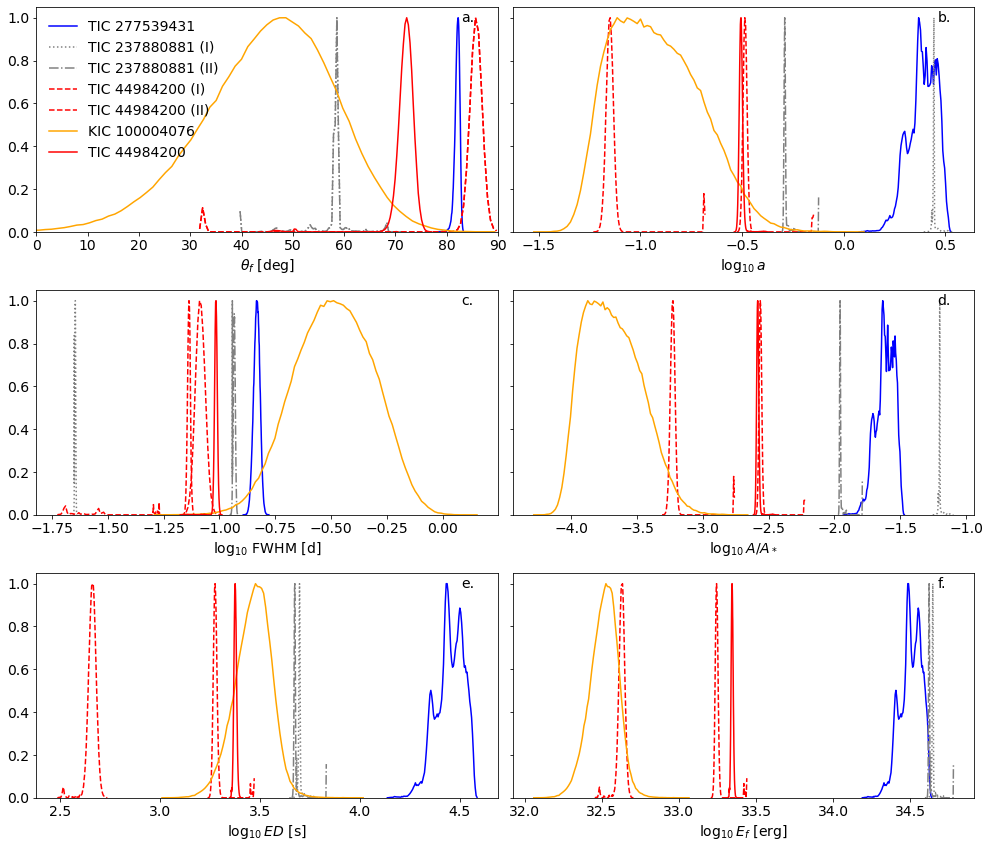

In [7]:
# Datasets we analysed
datasets = [(277539431, "", "08_07_2020_11_48"),
            (237880881, "a", "11_02_2020_10_07"),
            (237880881, "b", "11_02_2020_10_07"),
            (44984200, "a", "04_08_2020_13_40"),
            (44984200, "b", "04_08_2020_13_40"),
            (100004076, "", "18_08_2020_15_38"),
            (44984200, "", "02_08_2020_17_44"),
            ]
plotsuffix = {"a":" (I)", "b":" (II)", "":""}
columns = ["latitude_deg","a",
           "fwhm_d","frac_area",#"i_deg"#,"phase_deg","t0_d","rad_rsun"
           "ED_s","Eflare_erg"]

fig, axp = plt.subplots(ncols=2, nrows=3, figsize=(14,12), sharey=True)
axes = [a for ax in axp for a in ax]

for dataset in range(7):
    # What dataset do you want to analyse?
    ID, suffix, tstamp = datasets[dataset]

    # Pick up the input parameters
    CWD = "/".join(os.getcwd().split("/")[:-2])
    inits = pd.read_csv(f"{CWD}/data/summary/inits.csv")
    inits = inits[(inits.ID == str(ID)+suffix) &
                  (inits.tstamp==tstamp)].iloc[0]

    qlum = inits.qlum_erg_s * u.erg / u.s
    Fth = inits.Fth * u.erg / u.cm**2 / u.s
    median = inits['median']
    R = inits.R_Rsun * R_sun
    prefix = props[props.ID == ID].iloc[0].prefix


    # Pick up the LC
    lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{ID}.csv")

    # Load MCMC chain
    resultframe = pd.read_csv(f"{CWD}/analysis/results/mcmc/"
                              f"{tstamp}_{ID}{suffix}_converted_mcmc_sample.csv")
    
    for col in ["Eflare_erg", "fwhm_d", "a", "frac_area", "ED_s"]:
        resultframe[col] = np.log10(resultframe[col]) 
    old = resultframe.shape[1]

    if 'Unnamed: 0' in resultframe.columns:
        resultframe = resultframe.drop('Unnamed: 0', axis=1)

    choose = (outs.ID == ID) & (outs.suffix == suffix)
    color, linestyle = outs[choose].color.iloc[0], outs[choose].linestyle.iloc[0]
    
    
    for ax, col in zip(axes, columns):
        hist, bins = np.histogram(resultframe[col].values, bins=100)
        ax.plot((bins[1:] + bins[:-1])/2, hist/np.max(hist), linestyle=linestyle, color=color,
                 label=f"{prefix} {ID}{plotsuffix[suffix]}")
#         ax.hist(resultframe[col].values, 
#                 histtype="step", linewidth=2, #cumulative=True,#density=True,#log=True,
#                 linestyle=linestyle, color=color,
#                 label=f"{prefix} {ID}{suffix}")
        
        
valout = [#("t0_d", r"$t_0$ (BJD)"),
          ("latitude_deg", r"$\theta_f$ [deg]"),
          ("a",r"$\log_{10}\,a$"),
          ("fwhm_d", r"$\log_{10}$ FWHM [d]"),
          #("phase_deg",r"$\phi_0$ (deg)"),
          #("rad_rsun", r"$\omega/2$ (deg)"),
          ("frac_area", r"$\log_{10}\,A/A_*$"),
        #  ("i_deg",r"$i$ (deg)"),
          ("ED_s", r"$\log_{10}\,ED$ [s]"),
          ("Eflare_erg",r"$\log_{10}\,E_{f}$ [erg]"),
          ]       

for ax, col, lab in zip(axes, valout, "abcdef"):
    colb, colp = col
    ax.set_xlabel(colp)
    ax.set_ylim(bottom=0)
#     if colb in ["ED_s", "frac_area", "fwhm_d", "a"]:
#         ax.set_xscale("log")
    if colb in ["latitude_deg", "i_deg"]:
        ax.set_xlim(0,90)
    if colb in ["latitude_deg", "i_deg"]:
        ax.set_xlim(0,90)
    ax.text(0.92, 0.92, f"{lab}.", horizontalalignment='left',fontsize=14,
                         verticalalignment='bottom', transform=ax.transAxes)
axes[0].legend(loc=2, frameon=False)
plt.tight_layout(w_pad=.6)

# plt.savefig(f"{CWD}/analysis/plots/mcmc/all_together/{metatstamp}_posteriors.png",dpi=300)

In [5]:
dvalout = dict(valout)

In [6]:
pat = "/home/ekaterina/Documents/001_science/TESS_UCD_flares/flare_tables/20200227_vetted_flares_lacking_some.csv"
dftess = pd.read_csv(pat)
dftess = dftess[dftess.real == 1]
dftess.columns

Index(['Unnamed: 0', 'ampl_rec', 'cstart', 'cstop', 'ed_rec', 'ed_rec_err',
       'istart', 'istop', 'total_n_valid_data_points', 'tstart', 'tstop',
       'dur', 'ed_ratio', 'ed_ratio_count', 'amplitude_ratio',
       'amplitude_ratio_count', 'duration_ratio', 'duration_ratio_count',
       'amplitude_corr', 'duration_corr', 'ed_corr', 'recovery_probability',
       'recovery_probability_count', 'ed_ratio_std', 'amplitude_ratio_std',
       'duration_ratio_std', 'recovery_probability_std', 'ed_corr_err',
       'amplitude_corr_err', 'duration_corr_err', 'TIC', 'sector', 'energy',
       'st', 'real', 'complex'],
      dtype='object')

(-3.0, 1.0)

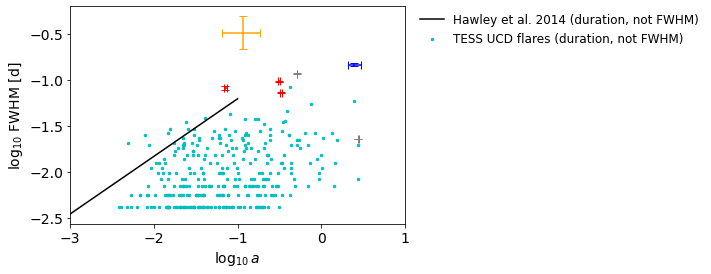

In [8]:
outs = pd.read_csv(f"{CWD}/analysis/results/mcmc/mcmcoutput.csv")
outs = outs.drop_duplicates(keep=False).fillna("")
for i, row in outs.iterrows():
    a  = np.log10(float(row.a_50))
    aup, alow =  np.log10(float(row.a_84)) - a, a - np.log10(float(row.a_16))
    fwhm  = np.log10(float(row.fwhm_d_50))
    fwhmup, fwhmlow =  np.log10(float(row.fwhm_d_84)) - fwhm, fwhm - np.log10(float(row.fwhm_d_16))
    plt.errorbar(x=[a],
                y=[fwhm],
                 xerr=np.array([aup,alow]).reshape((2,1)),
                 yerr=np.array([fwhmup,fwhmlow]).reshape((2,1)),
                color = row.color, capsize=4)

plt.plot([-3,-1],[np.log10(5/60/24),
                  np.log10(90/60/24)], 
         label="Hawley et al. 2014 (duration, not FWHM)",
        c="k")

plt.scatter(np.log10(dftess.ampl_rec), 
            np.log10(dftess.dur),
            label="TESS UCD flares (duration, not FWHM)",
            c="c", s=6)
plt.xlabel(dvalout["a"])
plt.ylabel(dvalout["fwhm_d"])
plt.legend(frameon=False, fontsize=12, loc=(1.03, .8));
plt.xlim(-3,1)

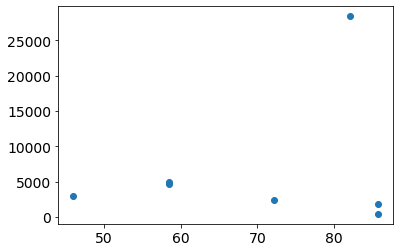

In [9]:
plt.scatter(outs.latitude_deg_50.astype(float), outs.ED_s_50.astype(float))

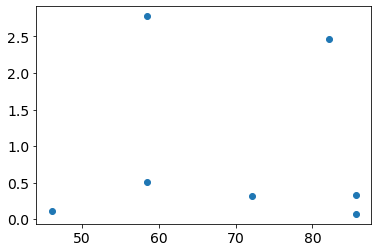

In [10]:
plt.scatter(outs.latitude_deg_50.astype(float), outs.a_50.astype(float))

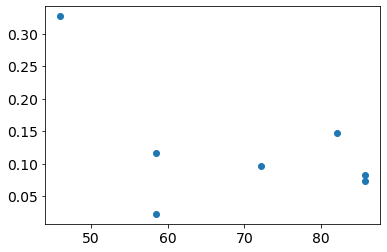

In [11]:
plt.scatter(outs.latitude_deg_50.astype(float), outs.fwhm_d_50.astype(float))

Text(0, 0.5, '$A/A_*$')

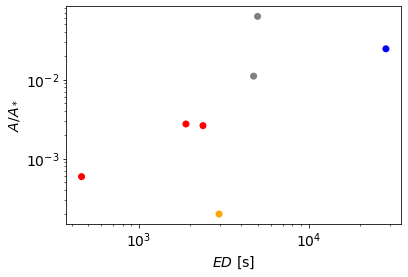

In [12]:
plt.scatter(outs.ED_s_50.astype(float), outs.frac_area_50.astype(float), c=outs.color)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$ED$ [s]")
plt.ylabel(r"$A/A_*$")

# Compare latitudes with sunspots

In [92]:
sun =  pd.read_csv(f"{CWD}/data/solar/sars.csv", skiprows=6)

In [93]:
coo = outs[["latitude_deg_50","latitude_deg_84","latitude_deg_16"]]
coo

,latitude_deg_50,latitude_deg_84,latitude_deg_16
0,82.105248,82.509906,81.601613
1,58.474348,58.791351,57.879569
2,58.474348,58.791351,57.879569
3,72.117878,73.373665,70.765983
4,85.671209,86.839343,84.416722
5,85.671209,86.839343,84.416722
6,46.047787,57.685142,32.342091


In [94]:
coo = np.sin(coo/180*np.pi)

In [ ]:

yup, ylow = coo.latitude_deg_84 - coo.latitude_deg_50, coo.latitude_deg_50 - coo.latitude_deg_16

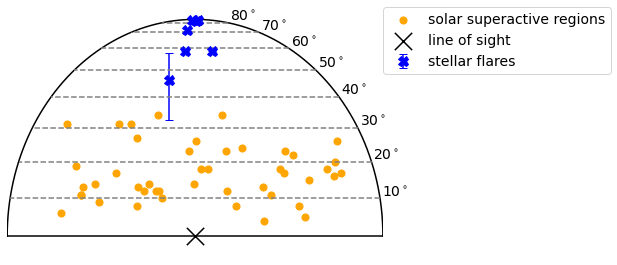

In [123]:
plt.figure(figsize=(8.8,4.))
lim = np.cos(outs.latitude_deg_50/180*np.pi)/4
plt.errorbar(-lim + 2*lim*np.random.rand(outs.shape[0]),
            coo.latitude_deg_50, yerr=np.array([ylow,yup,]),
            label="stellar flares", fmt="X", markersize=10, color="b", capsize=4)
plt.scatter(-.8 + 1.6*np.random.rand(sun.shape[0]),
            np.sin(sun.lat/180*np.pi),
            label="solar superactive regions", marker="o", s=50, c="orange")
x=np.linspace(0,np.pi,100)
plt.plot(np.cos(x), np.sin(x),c="k")
plt.plot(np.cos(x),[0]*len(x),c="k")
for la in [10,20,30,40,50,60,70,80]:
    ra = la/180*np.pi
    plt.text(np.cos(ra)+.01,np.sin(ra)+.01,fr"${la}^\circ$")
    plt.plot([np.cos(ra),-np.cos(ra)], [np.sin(ra),np.sin(ra)], c="grey", linestyle="dashed")
plt.scatter([0],[0],marker="x", s=300, c="k", label="line of sight")
plt.ylim(-.1,1.03)
plt.xlim(-1,1)
plt.axis("off")
plt.legend(loc=(1,.75))
plt.tight_layout()